# Modelo global do campo de gravidade eigen6c4

Este script mostra algumas quantidades preditas pelo modelo global do campo de gravidade **eigen-6C4** (Förste et al., 2014). Os coeficientes que descrevem este modelo estão no arquivo `eigen-6c4.gfc`, que pode ser baixado no site do IGCEM, na página [Table of models](http://icgem.gfz-potsdam.de/ICGEM/modelstab.html).

* Förste C., Bruinsma S.L., Abrikosov O., Lemoine J.-M., Schaller T., Götze H.-J., Ebbing J., Marty J.C., Flechtner F., Balmino G., Biancale R., 2014, EIGEN-6C4 The latest combined global gravity field model including GOCE data up to degree and order 2190 of GFZ Potsdam and GRGS Toulouse, 5th GOCE User Workshop, Paris, 25-28 November 2014, url: http://icgem.gfz-potsdam.de/ICGEM/documents/Foerste-et-al-EIGEN-6C4.pdf

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import minhas_funcoes as mf

### Dados baixados no IGCEM

De acordo com o IGCEM, os conjuntos de dados abaixo são provenientes de diferentes *Funcionais do Geopotencial* (*Functionals of the Geopotential*). No [*Calculation Service* do IGCEM](http://icgem.gfz-potsdam.de/ICGEM/Service.html) há uma legenda (figura abaixo) especificando cada tipo de dado.

<img src='functionals_geopotential.png', width=1000>

Todos dados foram baixados do [*Calculation Service* do IGCEM](http://icgem.gfz-potsdam.de/ICGEM/Service.html), estão armazenados nos arquivos `eigen-6c4-XXXXX.gdf.txt` e `etopo1-XXXXX.gdf.txt`, são referidos ao elipsoide WGS84 e foram calculados sobre o mesmo grid de coordenadas geodésicas espaçadas de $1^{\circ}$, variando de $0^{\circ}$ a $360^{\circ}$ ao longo da longitude $\lambda$ e de $-90^{\circ}$ a $90^{\circ}$ ao longo da latitude $\varphi$. 

**topography_grd**

In [2]:
longitude, latitude, topografia = np.loadtxt('etopo1-18001.gdf.txt', skiprows=29, unpack=True)

In [3]:
topografia[:10]

array([-4228., -4228., -4228., -4228., -4228., -4228., -4228., -4228.,
       -4228., -4228.])

In [4]:
topo_positiva = (topografia > 0.)
topo_negativa = (topografia < 0.)

In [5]:
topo_positiva[:10]

array([False, False, False, False, False, False, False, False, False, False], dtype=bool)

**gravity_disturbance**

In [6]:
altitude_ortometrica, disturbio = np.loadtxt('eigen-6c4-18000.gdf.txt', skiprows=35, usecols=(2,3), unpack=True)

**gravity_earth**

In [7]:
gravidade = np.loadtxt('eigen-6c4-18026.gdf.txt', skiprows=34, usecols=(3,), unpack=True)

**geoid**

In [8]:
geoide = np.loadtxt('eigen-6c4-18031.gdf.txt', skiprows=36, usecols=(2,), unpack=True)

**gravity_anomaly_cl**

In [9]:
an_gravidade = np.loadtxt('eigen-6c4-18444.gdf.txt', skiprows=35, usecols=(2,), unpack=True)

**gravity_anomaly_bg**

In [10]:
bouguer = np.loadtxt('eigen-6c4-18452.gdf.txt', skiprows=37, usecols=(2,), unpack=True)

### Coordenadas x y da projeção cartográfica

A projeção foi calculada com o [Basemap](http://matplotlib.org/basemap/users/index.html). Para os exemplos mostrados abaixo, a projeção escolhida foi a de [Robinson](http://matplotlib.org/basemap/users/robin.html).

In [11]:
m = Basemap(projection='robin',lon_0=0,resolution='c')
x, y = m(longitude, latitude)

### Parâmetros do datum geodésico WGS84

In [12]:
a, f, GM, omega = mf.WGS84()

### Gravidade normal sobre o elipsoide ($\mathbf{\gamma}_{0}$), sobre a topografia ($\mathbf{\gamma}$) e uma aproximação sobre a topografia ($\mathbf{\gamma}_{aprox}$)

In [13]:
gamma0 = mf.gamma_closedform(a, f, GM, omega, latitude, 
                             np.zeros_like(altitude_ortometrica))

In [14]:
gamma = mf.gamma_closedform(a, f, GM, omega, latitude, altitude_ortometrica)

In [15]:
gamma_aproximado = gamma0 - 0.3086*altitude_ortometrica

### Distúrbio de gravidade calculado $\delta g_{calc}$

In [16]:
disturbio_calculado = gravidade - gamma

### Anomalias de gravidade

**Constante Gravitacional** (ou [*Newtonian constant of gravitation*](http://physics.nist.gov/cgi-bin/cuu/Category?view=html&Universal.x=58&Universal.y=11)) em $\frac{m^{3}}{kg \, s^{2}}$

In [17]:
G = 6.67408e-11

**Correção Ar-livre**

In [18]:
ca = -0.3086*altitude_ortometrica

**Correção de Bouguer (platô)**

Neste cálculo foi considerado uma densidade de $\rho = 2670 \: \frac{kg}{m^{3}}$ para a correção sobre os continentes (altitudes positivas) e uma densidade de $\rho = (2670 - 1025)\: \frac{kg}{m^{3}}$ para a correção sobre os oceanos (altitudes negativas).

In [19]:
cb_continente = np.zeros_like(topografia)
cb_continente[topo_positiva] = 2.*np.pi*G*1.0e5*2670.*topografia[topo_positiva]

cb_oceano = np.zeros_like(topografia)
cb_oceano[topo_negativa] = 2.*np.pi*G*1.0e5*(2670. - 1025.)*topografia[topo_negativa]

cb = cb_continente + cb_oceano

**Anomalia Ar-livre**

In [45]:
ar_livre = an_gravidade - ca

**Anomalia Bouguer**

In [46]:
bouguer_calculada = an_gravidade - ca - cb

### Estatísticas e "mapas"

In [22]:
geoide_medio = np.mean(geoide)
geoide_min = np.min(geoide)
geoide_max = np.max(geoide)
dgeoide = geoide_max - geoide_min

print '     min.: %15.5f mGal' % geoide_min
print '    media: %15.5f mGal' % geoide_medio
print '     max.: %15.5f mGal' % geoide_max
print 'var. max.: %15.5f mGal' % dgeoide

     min.:      -106.18443 mGal
    media:        -0.86917 mGal
     max.:        84.91729 mGal
var. max.:       191.10172 mGal


C:\Anaconda\lib\site-packages\matplotlib\tri\triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


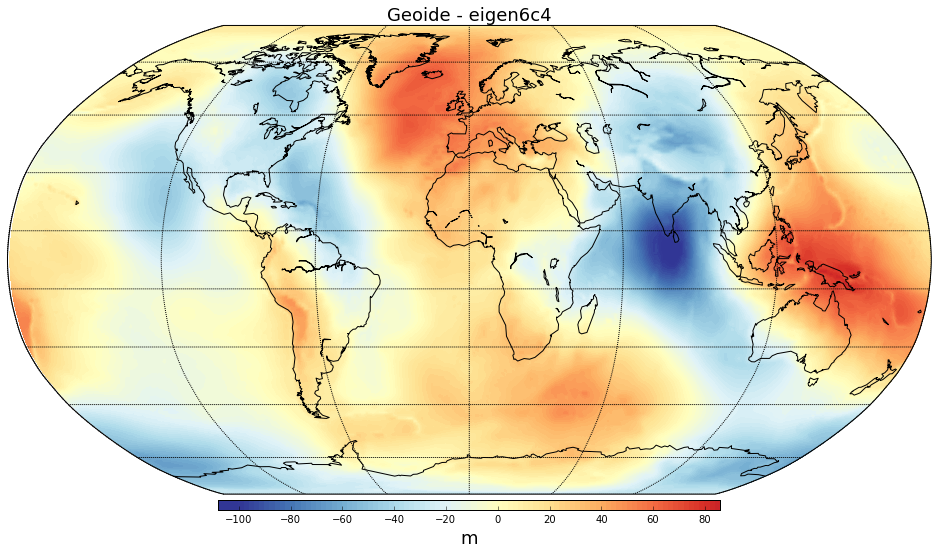

In [23]:
plt.figure(figsize=(18, 10))
plt.title('Geoide - eigen6c4', fontsize=18)
m.contourf(x, y, geoide, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          vmin = -100., vmax = 100.)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('m', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

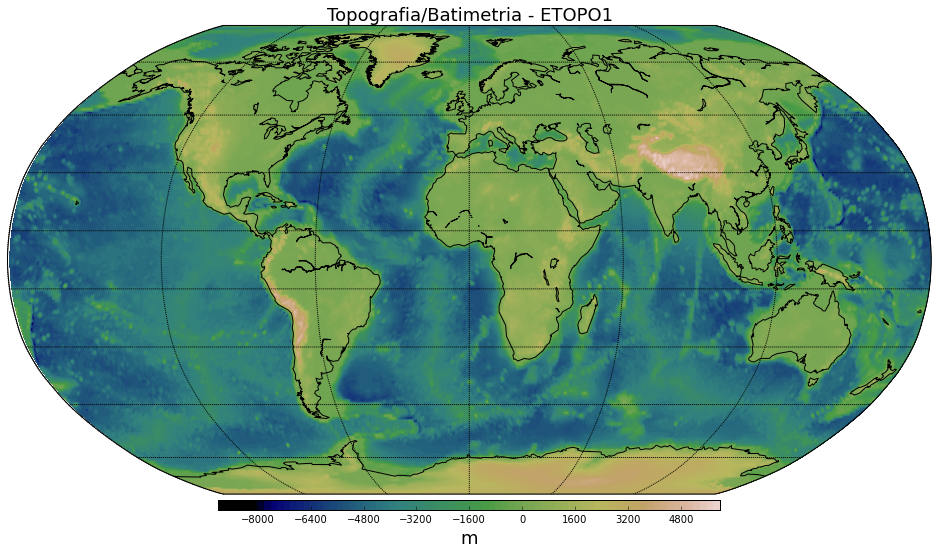

In [24]:
plt.figure(figsize=(18, 10))
plt.title('Topografia/Batimetria - ETOPO1', fontsize=18)
m.contourf(x, y, topografia, 100, tri=True, cmap=plt.cm.gist_earth,
          vmin = -8000., vmax = 6800.)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('m', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

In [25]:
gamma_medio = np.mean(gamma)
gamma_min = np.min(gamma)
gamma_max = np.max(gamma)
dgamma = gamma_max - gamma_min

print '     min.: %15.5f mGal' % gamma_min
print '    media: %15.5f mGal' % gamma_medio
print '     max.: %15.5f mGal' % gamma_max
print 'var. max.: %15.5f mGal' % dgamma

     min.:    976617.37984 mGal
    media:    980519.41489 mGal
     max.:    983218.49379 mGal
var. max.:      6601.11395 mGal


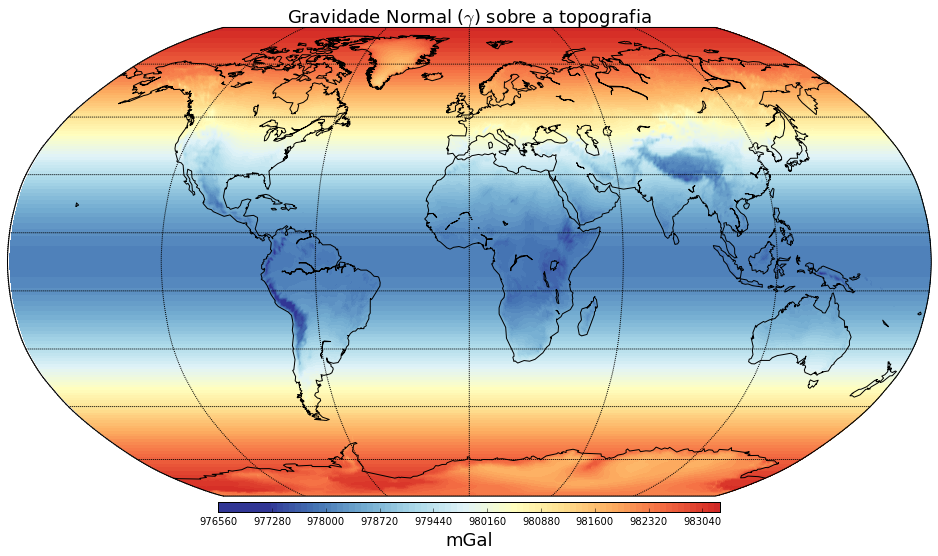

In [26]:
plt.figure(figsize=(18, 10))
plt.title('Gravidade Normal ($\gamma$) sobre a topografia', fontsize=18)
m.contourf(x, y, gamma, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          vmin = gamma_medio - 0.5*dgamma, vmax = gamma_medio + 0.5*dgamma)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('mGal', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

In [27]:
gamma_aprox_medio = np.mean(gamma_aproximado)
gamma_aprox_min = np.min(gamma_aproximado)
gamma_aprox_max = np.max(gamma_aproximado)
dgamma_aprox = gamma_aprox_max - gamma_aprox_min

print '     min.: %15.5f mGal' % gamma_aprox_min
print '    media: %15.5f mGal' % gamma_aprox_medio
print '     max.: %15.5f mGal' % gamma_aprox_max
print 'var. max.: %15.5f mGal' % dgamma_aprox

     min.:    976616.67679 mGal
    media:    980519.29420 mGal
     max.:    983218.49379 mGal
var. max.:      6601.81700 mGal


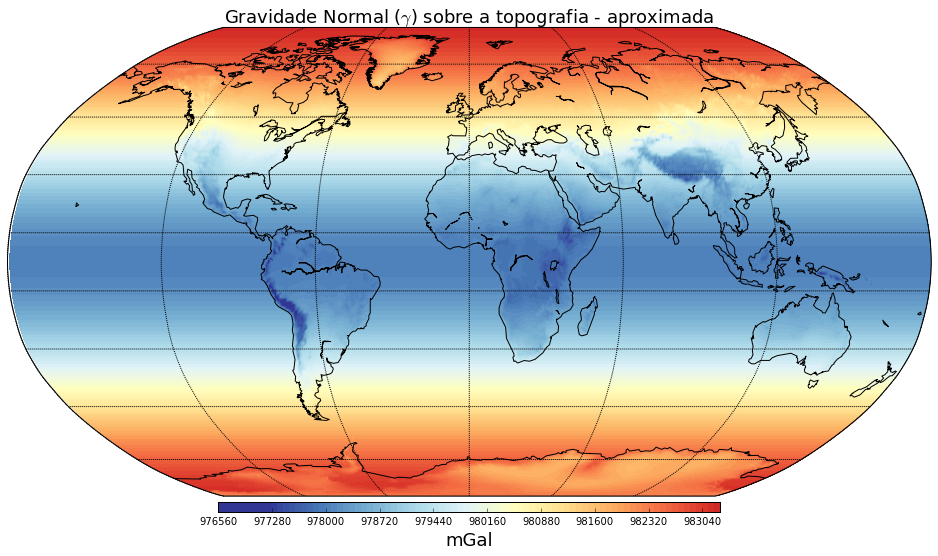

In [28]:
plt.figure(figsize=(18, 10))
plt.title('Gravidade Normal ($\gamma$) sobre a topografia - aproximada', fontsize=18)
m.contourf(x, y, gamma_aproximado, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          vmin = gamma_medio - 0.5*dgamma, vmax = gamma_medio + 0.5*dgamma)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('mGal', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

In [29]:
gamma0_medio = np.mean(gamma0)
gamma0_min = np.min(gamma0)
gamma0_max = np.max(gamma0)
dgamma0 = gamma0_max - gamma0_min

print '     min.: %15.5f mGal' % gamma0_min
print '    media: %15.5f mGal' % gamma0_medio
print '     max.: %15.5f mGal' % gamma0_max
print 'var. max.: %15.5f mGal' % dgamma0

     min.:    978032.53359 mGal
    media:    980636.98701 mGal
     max.:    983218.49379 mGal
var. max.:      5185.96020 mGal


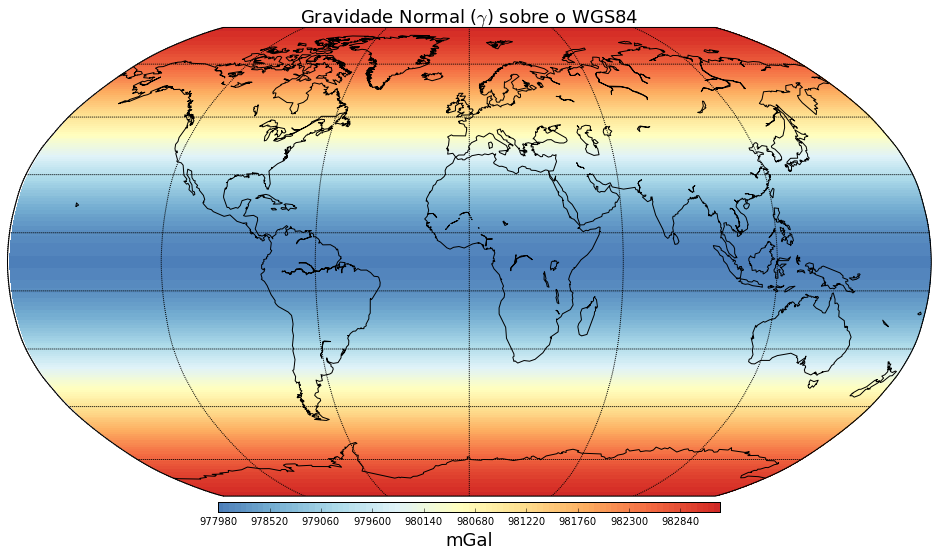

In [30]:
plt.figure(figsize=(18, 10))
plt.title('Gravidade Normal ($\gamma$) sobre o WGS84', fontsize=18)
m.contourf(x, y, gamma0, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          #vmin = gamma0_medio - 0.5*dgamma0, vmax = gamma0_medio + 0.5*dgamma0)
           vmin = gamma_medio - 0.5*dgamma, vmax = gamma_medio + 0.5*dgamma)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('mGal', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

In [31]:
grav_media = np.mean(gravidade)
grav_min = np.min(gravidade)
grav_max = np.max(gravidade)
dgrav = grav_max - grav_min

print '     min.: %15.5f mGal' % grav_min
print '    media: %15.5f mGal' % grav_media
print '     max.: %15.5f mGal' % grav_max
print 'var. max.: %15.5f mGal' % dgrav

     min.:    976832.72204 mGal
    media:    980518.95501 mGal
     max.:    983296.63864 mGal
var. max.:      6463.91660 mGal


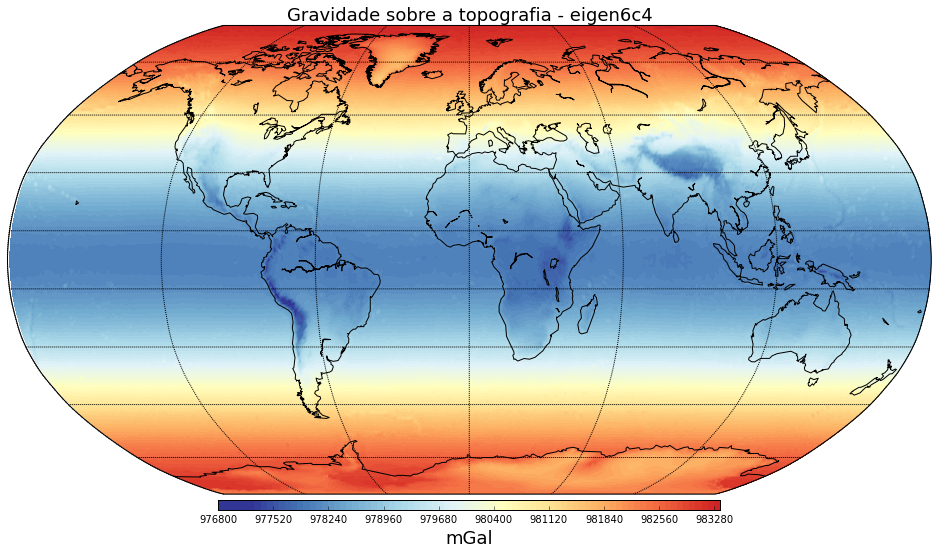

In [32]:
plt.figure(figsize=(18, 10))
plt.title('Gravidade sobre a topografia - eigen6c4', fontsize=18)
m.contourf(x, y, gravidade, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          #vmin = grav_media - 0.5*dgrav, vmax = grav_media + 0.5*dgrav)
          vmin = gamma_medio - 0.5*dgamma, vmax = gamma_medio + 0.5*dgamma)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('mGal', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

In [33]:
dist_medio_calculado = np.mean(disturbio_calculado)
dist_min_calculado = np.min(disturbio_calculado)
dist_max_calculado = np.max(disturbio_calculado)
ddist_calculado = dist_max_calculado - dist_min_calculado

print '     min.: %15.5f mGal' % dist_min_calculado
print '    media: %15.5f mGal' % dist_medio_calculado
print '     max.: %15.5f mGal' % dist_max_calculado
print 'var. max.: %15.5f mGal' % ddist_calculado

     min.:      -301.30098 mGal
    media:        -0.45988 mGal
     max.:       384.91454 mGal
var. max.:       686.21552 mGal


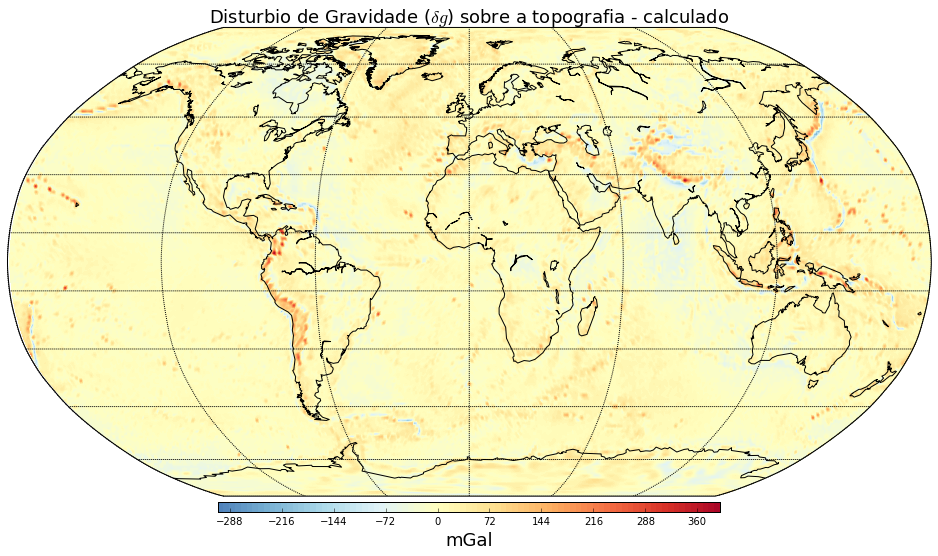

In [34]:
plt.figure(figsize=(18, 10))
plt.title('Disturbio de Gravidade ($\delta g$) sobre a topografia - calculado', fontsize=18)
m.contourf(x, y, disturbio_calculado, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          vmin = -400., vmax = 400.)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('mGal', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

In [35]:
dist_medio_eigen6c4 = np.mean(disturbio)
dist_min_eigen6c4 = np.min(disturbio)
dist_max_eigen6c4 = np.max(disturbio)
ddist_eigen6c4 = dist_max_eigen6c4 - dist_min_eigen6c4

print '     min.: %15.5f mGal' % dist_min_eigen6c4
print '    media: %15.5f mGal' % dist_medio_eigen6c4
print '     max.: %15.5f mGal' % dist_max_eigen6c4
print 'var. max.: %15.5f mGal' % ddist_eigen6c4

     min.:      -302.16113 mGal
    media:        -0.72717 mGal
     max.:       394.95950 mGal
var. max.:       697.12063 mGal


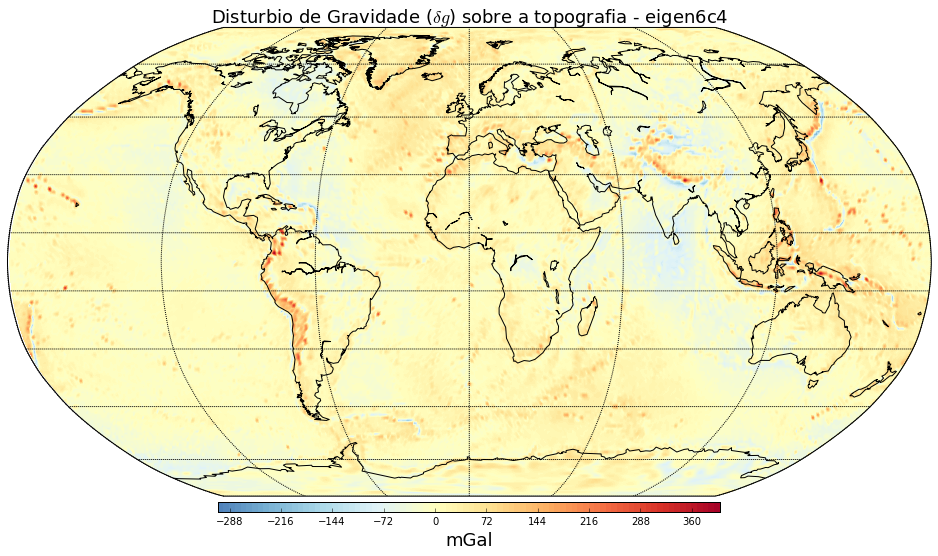

In [36]:
plt.figure(figsize=(18, 10))
plt.title('Disturbio de Gravidade ($\delta g$) sobre a topografia - eigen6c4', fontsize=18)
m.contourf(x, y, disturbio, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          vmin = -400., vmax = 400.)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('mGal', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

In [37]:
an_gravidade_media = np.mean(an_gravidade)
an_gravidade_min = np.min(an_gravidade)
an_gravidade_max = np.max(an_gravidade)
dan_gravidade = an_gravidade_max - an_gravidade_min

print '     min.: %15.5f mGal' % an_gravidade_min
print '    media: %15.5f mGal' % an_gravidade_media
print '     max.: %15.5f mGal' % an_gravidade_max
print 'var. max.: %15.5f mGal' % dan_gravidade

     min.:      -301.30098 mGal
    media:        -0.32256 mGal
     max.:       522.25583 mGal
var. max.:       823.55681 mGal


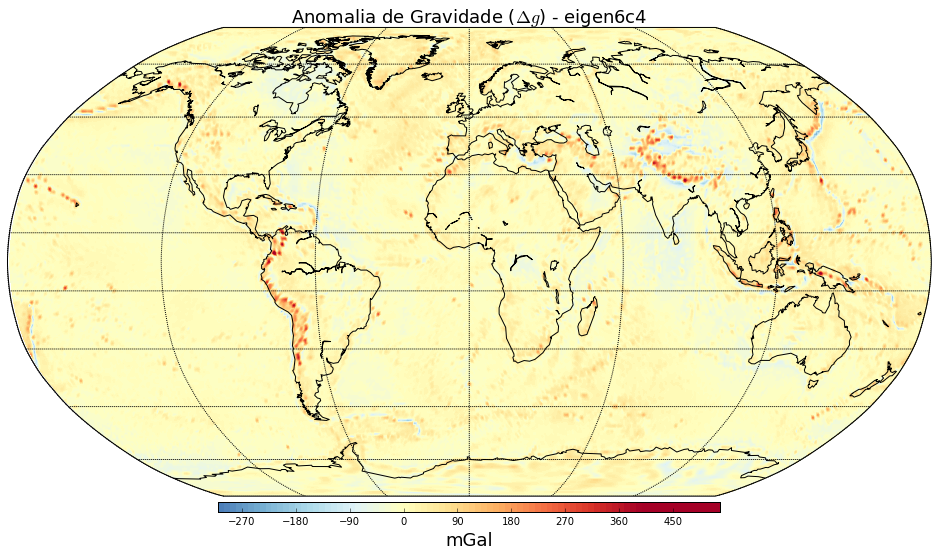

In [38]:
plt.figure(figsize=(18, 10))
plt.title('Anomalia de Gravidade ($\Delta g$) - eigen6c4', fontsize=18)
m.contourf(x, y, an_gravidade, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          vmin = -400., vmax = 400.)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('mGal', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

In [47]:
ar_livre_media = np.mean(ar_livre)
ar_livre_min = np.min(ar_livre)
ar_livre_max = np.max(ar_livre)
dar_livre = ar_livre_max - ar_livre_min

print '     min.: %15.5f mGal' % ar_livre_min
print '    media: %15.5f mGal' % ar_livre_media
print '     max.: %15.5f mGal' % ar_livre_max
print 'var. max.: %15.5f mGal' % dar_livre

     min.:      -301.30098 mGal
    media:       117.37025 mGal
     max.:      2110.01503 mGal
var. max.:      2411.31601 mGal


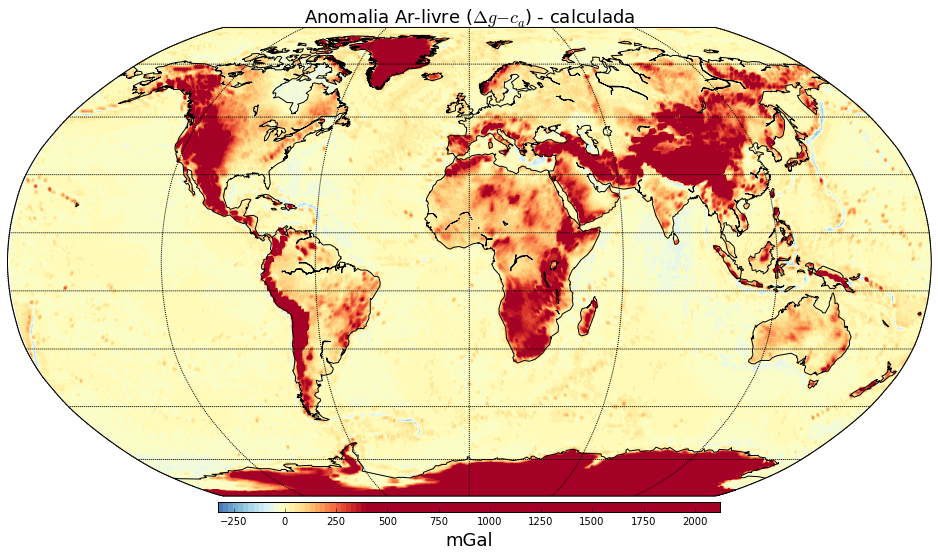

In [48]:
plt.figure(figsize=(18, 10))
plt.title('Anomalia Ar-livre ($\Delta g - c_{a}$) - calculada', fontsize=18)
m.contourf(x, y, ar_livre, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          vmin = -400., vmax = 400.)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('mGal', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

In [41]:
bouguer_media = np.mean(bouguer)
bouguer_min = np.min(bouguer)
bouguer_max = np.max(bouguer)
dbouguer = bouguer_max - bouguer_min

print '     min.: %15.5f mGal' % bouguer_min
print '    media: %15.5f mGal' % bouguer_media
print '     max.: %15.5f mGal' % bouguer_max
print 'var. max.: %15.5f mGal' % dbouguer

     min.:      -631.21824 mGal
    media:       113.29139 mGal
     max.:       455.45617 mGal
var. max.:      1086.67440 mGal


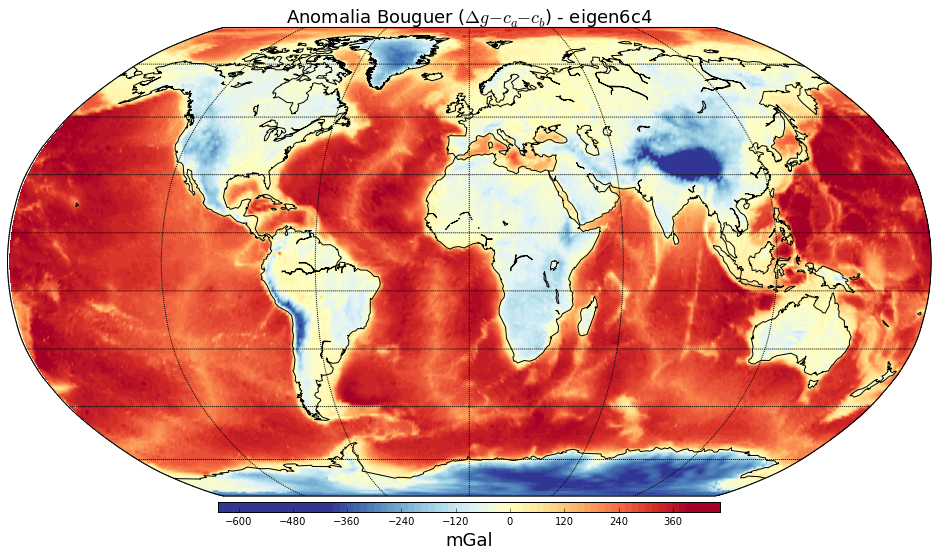

In [42]:
plt.figure(figsize=(18, 10))
plt.title('Anomalia Bouguer ($\Delta g - c_{a} - c_{b}$) - eigen6c4', fontsize=18)
m.contourf(x, y, bouguer, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          vmin = -400., vmax = 400.)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('mGal', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()

In [49]:
bouguer_calculada_media = np.mean(bouguer_calculada)
bouguer_calculada_min = np.min(bouguer_calculada)
bouguer_calculada_max = np.max(bouguer_calculada)
dbouguer_calculada = bouguer_calculada_max - bouguer_calculada_min

print '     min.: %15.5f mGal' % bouguer_calculada_min
print '    media: %15.5f mGal' % bouguer_calculada_media
print '     max.: %15.5f mGal' % bouguer_calculada_max
print 'var. max.: %15.5f mGal' % dbouguer_calculada

     min.:      -180.11850 mGal
    media:       231.01159 mGal
     max.:      1507.64298 mGal
var. max.:      1687.76148 mGal


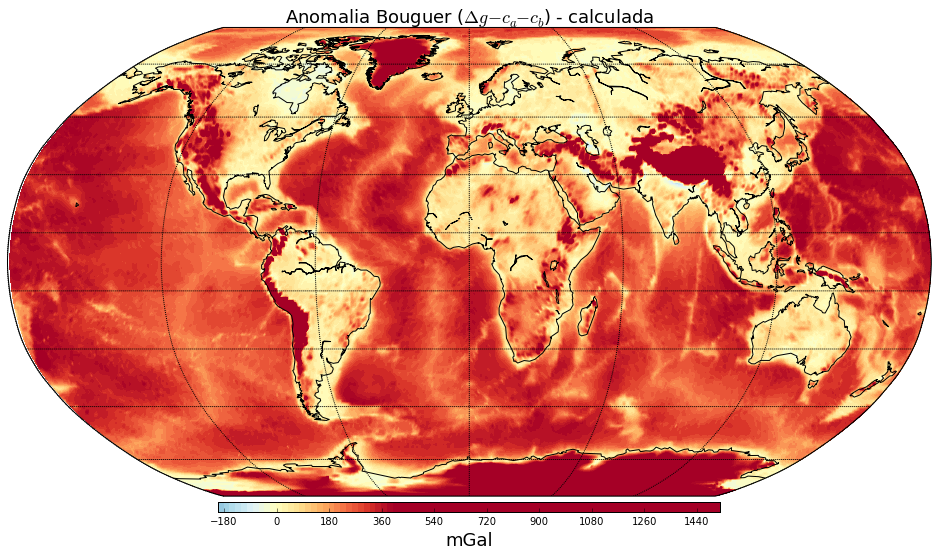

In [50]:
plt.figure(figsize=(18, 10))
plt.title('Anomalia Bouguer ($\Delta g - c_{a} - c_{b}$) - calculada', fontsize=18)
m.contourf(x, y, bouguer_calculada, 100, tri=True, cmap=plt.cm.RdYlBu_r,
          vmin = -400., vmax = 400.)
plt.colorbar(orientation='horizontal', pad=0.01, aspect=50, 
             shrink=0.5).set_label('mGal', fontsize=18)
m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,20.))
m.drawmeridians(np.arange(0.,360.,60.))
plt.show()